## Notebook to determine ROIs for overlapping cells in 3d spot-based transcriptomics data

In [1]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
# a


#### Basic imports:

In [2]:
import os
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import anndata

# import ssam

#### Define parameters

In [3]:
# SSAM vector field resolution:
um_per_pixel = 3.0

# SSAM pandwidth:
bw = 1

# KNN diffusion iterations to move spots to z-axis zero mean:
z_centralization_iters = 20

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


## Define & load data

####  0: Xenium Mouse brain dataset:

In [5]:

if dataset == 0:

    # adata = anndata.read_h5ad(os.path.join(file_root,'../../data/z-incoherence/counts_WS_blur5_exp0.h5ad'))

    # coords_louis = adata.uns['spots'].copy()

    adata = anndata.read_h5ad(os.path.join(file_root,'../../data/z-incoherence/ms_brain_rep2.h5ad'),)

    coords = adata.uns['spots'].copy()

    coords = coords[~(coords.feature_name.str.contains("BLANK") | coords.feature_name.str.contains("NegControl"))]

    # coords['cell_id_louis'] = coords_louis['cell'].to_numpy()
    # coords['cell_type_louis'] = list(coords_louis['celltype'])

    # del adata, coords_louis
#     adata = anndata.read_h5ad('../../data/z-incoherence/reads_to_ref_scRNAseq_cluster_sample2.csv')

    spot_df_raw = coords[['x_location' ,'y_location' ,'z_location','feature_name' ]]#,'cell_id','cell_type_louis','cell_id_louis']]

    # replace the feature_name Ccn2 with Ctgf, which is present in the scRNAseq data:
    spot_df_raw.loc[spot_df_raw.feature_name=='Ccn2','feature_name'] = 'Ctgf'

    # spot_df_raw=spot_df_raw[['global_x','global_y','global_z','gene']]
    spot_df_raw.columns = ['x','y','z','gene' ,]#'cell_id','cell_type_louis','cell_id_louis']

    # x_,_x,y_,_y = 1000,9000,1000,9000
    # spatial_mask =  (spot_df_raw.x>x_)&(spot_df_raw.x<_x)&\
    #                 (spot_df_raw.y>x_)&(spot_df_raw.y<_y)

    # spot_df_raw = spot_df_raw[spatial_mask]

    # Remove 'blank' genes:
    spot_df_raw = spot_df_raw[~spot_df_raw.gene.str.contains('Blank')][::1]

    spot_df_raw['gene']=spot_df_raw['gene'].astype('category')

    # spot_df = spot_df_raw.copy()
    genes = sorted(spot_df_raw.gene.unique())


del coords

spot_df_raw.x-=spot_df_raw.x.min()
spot_df_raw.y-=spot_df_raw.y.min()

spot_df_raw.x/=um_per_pixel
spot_df_raw.y/=um_per_pixel

spot_df_raw


x           y          z     gene
transcript_id                                              
281496451547136   35.426836  395.499727  15.111133     Dkk3
281496451547137  199.002182  403.339894  13.810570  Neurod6
281496451547138   12.580175  653.850460  14.667373   Ipcef1
281496451547139   10.706665  670.733527  15.058671  Bhlhe40
281496451547140  206.995582  347.995094  15.842804     Car4
...                     ...         ...        ...      ...
281513631904696  912.048682  572.527094  28.736680    Cdh13
281513631904697  871.974916  579.592960  29.148848     Fign
281513631904698  968.452482  602.523894  28.413157   Zfp536
281513631904699  928.442249  612.646494  29.233194    Cd24a
281513631904700  971.021182  659.086360  28.660988  Rasgrf2

[9451292 rows x 4 columns]

In [6]:
from src import ovrlp

ovrlp.assign_xy(spot_df_raw)

x           y          z     gene  x_pixel  y_pixel  \
transcript_id                                                                   
281496451547136   35.426836  395.499727  15.111133     Dkk3       35      395   
281496451547137  199.002182  403.339894  13.810570  Neurod6      199      403   
281496451547138   12.580175  653.850460  14.667373   Ipcef1       12      653   
281496451547139   10.706665  670.733527  15.058671  Bhlhe40       10      670   
281496451547140  206.995582  347.995094  15.842804     Car4      206      347   
...                     ...         ...        ...      ...      ...      ...   
281513631904696  912.048682  572.527094  28.736680    Cdh13      912      572   
281513631904697  871.974916  579.592960  29.148848     Fign      871      579   
281513631904698  968.452482  602.523894  28.413157   Zfp536      968      602   
281513631904699  928.442249  612.646494  29.233194    Cd24a      928      612   
281513631904700  971.021182  659.086360  28.660988  Rasgrf2      971      659   

                 n_pixel  
transcript_id             
281496451547136   385160  
281496451547137   393124  
281496451547138   636687  
281496451547139   653260  
281496451547140   338531  
...                  ...  
281513631904696   558612  
281513631904697   565396  
281513631904698   587918  
281513631904699   597628  
281513631904700   643496  

[9451292 rows x 7 columns]

In [7]:
median = ovrlp.assign_z_median(spot_df_raw)
 #spot_df_raw.z>((spot_df_raw.z.max()-spot_df_raw.z.min())/2)

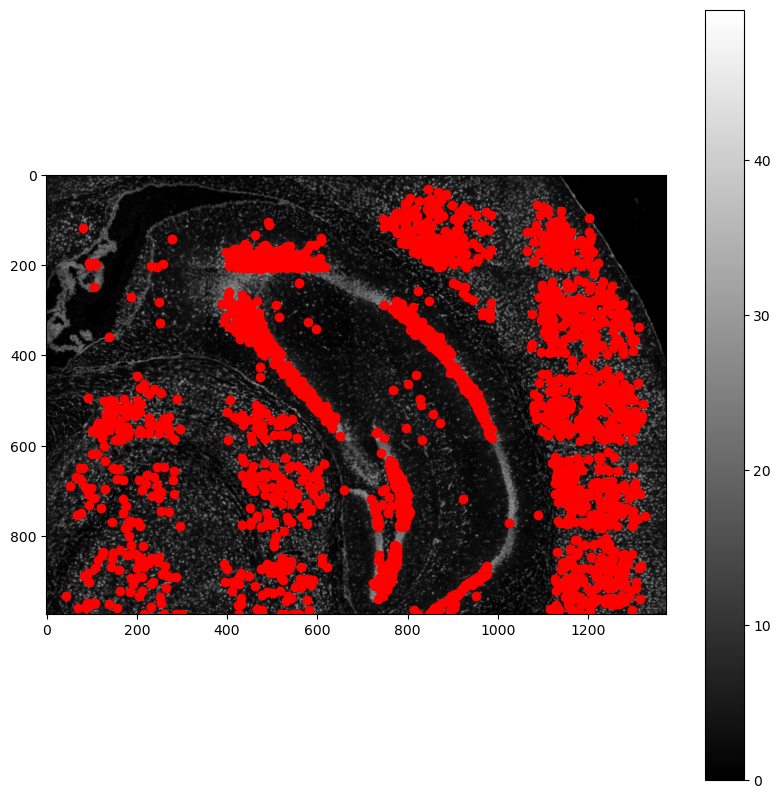

In [8]:
plt.figure(figsize=(10,10))
rois_x,rois_y = ovrlp.get_rois(spot_df_raw, min_distance=3, KDE_bandwidth = 1, min_expression = 15)


In [8]:
%load_ext autoreload
%autoreload 2

expressions_top, expressions_bottom, expressions = ovrlp.get_expression_vectors_at_rois(spot_df_raw,rois_x,rois_y)

9134
9066


In [9]:
# cos_sim = np.nan_to_num(((expressions[0]/expressions[0].sum(axis=1,keepdims=True)**2)**0.5 * \
#             (expressions[1]/expressions[1].sum(axis=1,keepdims=True)**2)**0.5).sum(1))

expressions_top = expressions[0]
expressions_bottom = expressions[1]

expressions_top_z = expressions_top-expressions_top.mean(1,keepdims=True)
expressions_bottom_z = expressions_bottom-expressions_bottom.mean(1,keepdims=True)

expressions_top_z = expressions_top_z/expressions_top_z.std(1,keepdims=True)
expressions_bottom_z = expressions_bottom_z/expressions_bottom_z.std(1,keepdims=True)

correlation = (expressions_top_z*expressions_bottom_z).mean(1)

In [10]:
correlation

array([ 0.6354229 ,  0.84068246,  0.77389244,  0.92784868,  0.6556199 ,
        0.86378092,  0.56750322,  0.80855223,  0.4773432 ,  0.44349278,
        0.7055859 ,  0.48693701,  0.80589565,  0.82767412,  0.75192454,
        0.78158316,  0.6958928 ,  0.37424249,  0.26093231,  0.47062621,
        0.70195073,  0.72855022,  0.56806221,  0.28291128,  0.27279109,
        0.6948928 ,  0.70306722,  0.54112732,  0.60058894,  0.47104983,
        0.69905307,  0.63400578,  0.52784108,  0.546301  ,  0.68039388,
        0.54717286,  0.67016807,  0.58852952,  0.56278885,  0.72352108,
        0.73642818,  0.7400052 ,  0.32278236,  0.76245146,  0.68547934,
        0.81316929,  0.30979627,  0.33006015,  0.31335527,  0.78052394,
        0.68507743,  0.73858978,  0.54527301,  0.49571195,  0.61112898,
        0.31145771,  0.47474039,  0.47086618,  0.71034033,  0.61975233,
        0.29947669,  0.52187635,  0.70992725,  0.51009858,  0.66658407,
        0.46901086,  0.67346309,  0.46681243,  0.31505389,  0.38

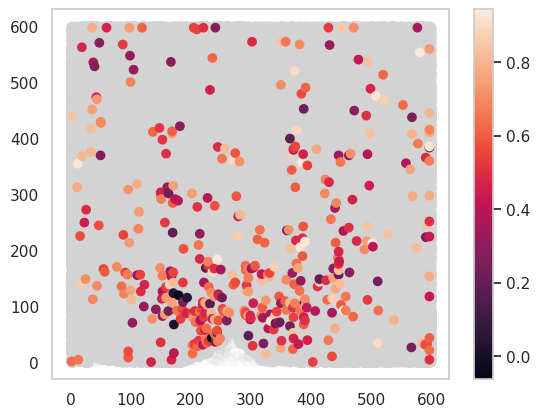

In [11]:
plt.scatter(spot_df_raw.x,spot_df_raw.y,color='lightgrey',alpha=0.1)
plt.scatter(rois_x,rois_y,c=correlation)
plt.colorbar()

In [12]:
# assert False 

In [13]:
import time
from  tqdm.notebook import tqdm
from scipy.signal import fftconvolve

hists_top = np.zeros((spot_df_raw.x_pixel.max()+1,spot_df_raw.y_pixel.max()+1,len(genes)))
hists_bottom = np.zeros((spot_df_raw.x_pixel.max()+1,spot_df_raw.y_pixel.max()+1,len(genes)))

starting_time = time.perf_counter()


def create_circular_kernel(kernel_width):
    span = np.linspace(-1,1,kernel_width)
    X,Y = np.meshgrid(span,span)
    return (X**2+Y**2)**0.5<=1

kernel_width = 2

circular_kernel = create_circular_kernel(kernel_width)

if kernel_width<3:
    circular_kernel[:]=1

hist_bins = [np.arange(hists_top.shape[0]+1),np.arange(hists_top.shape[1]+1)]

for i,g in (t_bar := tqdm(enumerate(genes),total=len(genes))):

    t_bar.set_description(g)
    subsample = spot_df_raw[spot_df_raw.gene==g]

    subsample_top = subsample[subsample.z>=subsample.z_pixel_median]
    hist_top,_,_ = np.histogram2d(subsample_top.x_pixel,subsample_top.y_pixel,bins=hist_bins)

    subsample_bottom = subsample[subsample.z<=subsample.z_pixel_median]
    hist_bottom,_,_ = np.histogram2d(subsample_bottom.x_pixel,subsample_bottom.y_pixel,bins=hist_bins)

    hists_top[:,:,i] = fftconvolve(hist_top,circular_kernel,mode='same')
    hists_bottom[:,:,i] = fftconvolve(hist_bottom,circular_kernel,mode='same')

hists_top = np.round(np.log(hists_top+1)).astype(int)
hists_bottom = np.round(np.log(hists_bottom+1)).astype(int)

del hist_top, hist_bottom

cosine_similarity = (hists_top / (hists_top**2).sum(-1,keepdims=True)**0.5 * hists_bottom/(hists_bottom**2).sum(-1,keepdims=True)**0.5).sum(-1)



  0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_1719923/2733073827.py:44: RuntimeWarning: invalid value encountered in true_divide
  cosine_similarity = (hists_top / (hists_top**2).sum(-1,keepdims=True)**0.5 * hists_bottom/(hists_bottom**2).sum(-1,keepdims=True)**0.5).sum(-1)


In [14]:
# # use determine the hypergeom probability for each pixel:

# from scipy.stats import multivariate_hypergeom

# def hypergeom_prob_bottom(data):
#     if data.sum()<2:
#         return 1
#     else:
#         top_counts = data[:len(genes)]
#         bottom_counts = data[len(genes):]
#         return multivariate_hypergeom.pmf(bottom_counts,top_counts+bottom_counts,bottom_counts.sum())


In [15]:
# from multiprocessing import pool


# with pool.Pool(1000) as p:
#     p_bottom = p.map(hypergeom_prob_bottom,np.concatenate([hists_bottom,hists_top],-1)[:,:].reshape(-1,2*len(genes)),chunksize=1000)

# p_bottom = np.array(p_bottom).reshape(hists_bottom.shape[:2])

In [16]:
# # Detect local maxima in p_bottom:

# from scipy import ndimage

# kernel_width = 30
# maximum_footprint = create_circular_kernel(kernel_width)

# p_min = 0.1
# # p_bottom_gaussiansmoothed = ndimage.gaussian_filter(-p_bottom, sigma=0.5)
# p_bottom_gaussiansmoothed = ndimage.gaussian_filter(-p_bottom, sigma=0.5)
# result = ndimage.maximum_filter(p_bottom_gaussiansmoothed, footprint=maximum_footprint, mode='constant', cval=0)

# localmaxs = np.array(np.where(((result==p_bottom_gaussiansmoothed)&(p_bottom<p_min)))).T

# idcs = np.argsort(p_bottom_gaussiansmoothed[localmaxs[:,0],localmaxs[:,1]])[::-1]

# plt.figure(figsize=(15,7))
# plt.imshow(p_bottom_gaussiansmoothed,cmap='Greys')
# plt.colorbar()
# plt.scatter(localmaxs[:,1],localmaxs[:,0],c=idcs,marker='.',alpha=0.5,s=50)


In [17]:
# # Create a four-panel figure showing the molecules of spot_df_raw aroud the most significant local maxima:

# from matplotlib import gridspec

# fig = plt.figure(figsize=(8,8))
# gs = gridspec.GridSpec(2, 2, figure=fig)

# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[1, 0])
# ax4 = fig.add_subplot(gs[1, 1])

# axs = [ax1,ax2,ax3,ax4]

# for i,ax in enumerate(axs):
#     x,y = localmaxs[idcs[i]]
#     x = (x*um_per_pixel+spot_df_raw.x.min())
#     y = (y*um_per_pixel+spot_df_raw.y.min())
#     ax.scatter(spot_df_raw.x[:],spot_df_raw.y[:],c='k',alpha=0.1,s=1)
#     ax.scatter(x,y,c='r',s=50)
#     ax.set_xlim(x-40,x+40)
#     ax.set_ylim(y-40,y+40)


In [18]:
# hists_top.sum(-1)

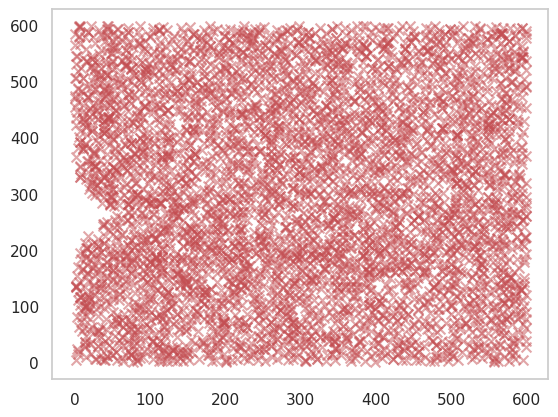

In [19]:
# A quick re-implementation of the SSAM-algorithm to determine celltypes:
# detect local maxima in the aggregated top and bottom counts:

from scipy import ndimage

local_max_radius = 10
local_max_footprint = create_circular_kernel(local_max_radius)

local_median_radius = 30
local_median_footprint = create_circular_kernel(local_median_radius)

aggregated_signal = hists_bottom.sum(-1)+hists_top.sum(-1)
aggregated_signal = ndimage.gaussian_filter(aggregated_signal, sigma=1)
max_filtered_signal = ndimage.maximum_filter(aggregated_signal, footprint=local_max_footprint, )
median_filtered_signal = ndimage.median_filter(aggregated_signal, footprint=local_median_footprint, )

min_cells = 10

localmaxs_celltyping = np.array(np.where((max_filtered_signal==aggregated_signal)&
                                         ((median_filtered_signal*0)<aggregated_signal) & 
                                         (median_filtered_signal>0)&(hists_top.sum(-1)>min_cells)&(hists_bottom.sum(-1)>min_cells))).T

# gene expression vector samples at the detected local maxima:
localmax_celltyping_samples = np.concatenate([hists_top[localmaxs_celltyping[:,0],localmaxs_celltyping[:,1],:],
                                              hists_bottom[localmaxs_celltyping[:,0],localmaxs_celltyping[:,1],:]],0)
localmax_celltyping_samples = localmax_celltyping_samples/(localmax_celltyping_samples**2).sum(1,keepdims=True)**0.5

# del aggregated_signal,median_filtered_signal,max_filtered_signal

plt.scatter(localmaxs_celltyping[:,1],localmaxs_celltyping[:,0],c='r',marker='x',alpha=0.5,s=50)


#### This cell contains helper functions from the UMAP2RGB package (alpha):

In [20]:
from sklearn.decomposition import PCA as Dimred


def fill_color_axes(rgb,dimred=None):

    if dimred is None:
        dimred = Dimred(n_components=3)
        dimred.fit(rgb)

    facs = dimred.transform(rgb)

    # rotate the ica_facs 45 in all the dimensions:
    # define a 45-degree 3d rotation matrix 
    # (0.500 | 0.500 | -0.707
    # -0.146 | 0.854 | 0.500
    # 0.854 | -0.146 | 0.500)
    rotation_matrix = np.array([[0.500,0.500,-0.707],
                                [-0.146,0.854,0.500],
                                [0.854,-0.146,0.500]])

    # rotate the facs:
    facs = np.dot(facs,rotation_matrix)


    return facs,dimred


# create circular kernel:
def create_circular_kernel(kernel_width):
    span = np.linspace(-1,1,kernel_width)
    X,Y = np.meshgrid(span,span)
    return (X**2+Y**2)**0.5<=1


# normalize array:
def min_to_max(arr):
    arr=arr-arr.min(0,keepdims=True)
    arr/=arr.max(0,keepdims=True)
    return arr

# convert cymk to rgb:
def cymk_to_rgb(cymk):
    c,y,m,k = cymk.T
    r = (1-c)*(1-k)
    g = (1-m)*(1-k)
    b = (1-y)*(1-k)
    return np.array([r,g,b]).T

def haversine_to_rgb(embedding):
    r = np.cos(embedding[:,0])*np.sin(embedding[:,1])
    g = np.sin(embedding[:,0])*np.sin(embedding[:,1])
    b = np.cos(embedding[:,1])
    return np.array([r,g,b]).T

def visualize_rgb_scale(rgb):
    fig = plt.figure(figsize=(15,7))

    ax1 = fig.add_subplot(121)
    ax1.scatter(embeddings_2d[:,0],embeddings_2d[:,1],c=rgb,alpha=0.5)
    plot_label_coords()

    ax2 = fig.add_subplot(122,projection='3d')
    ax2.scatter(rgb[:,0],rgb[:,1],rgb[:,2],c=rgb,alpha=0.5)

    plt.tight_layout()



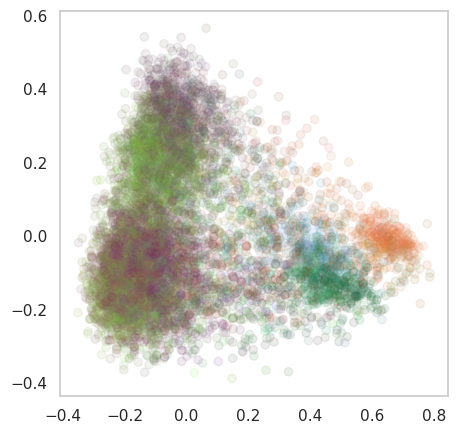

In [21]:
from sklearn.decomposition import PCA as dim_reduction

pca = dim_reduction(n_components=100)
factors = pca.fit_transform(localmax_celltyping_samples)

colors = min_to_max(factors[:,2:5])

plt.figure(figsize=(5,5))

plt.scatter(factors[:,0],factors[:,1],c=colors,alpha=0.1)


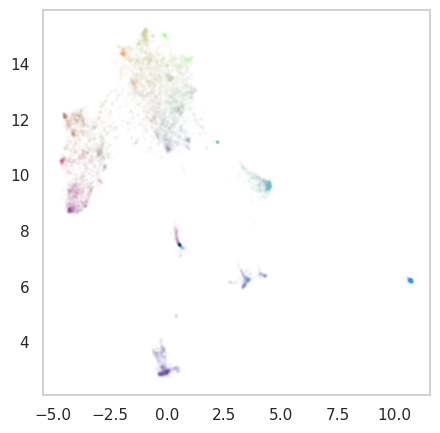

In [22]:
import umap

embedder_2d = umap.UMAP(n_components=2,min_dist=0.0)
embedding = embedder_2d.fit_transform(factors)

embedder_3d = umap.UMAP(n_components=3, min_dist=0.0,n_neighbors=10,
                  init=np.concatenate([embedding,0.1*np.random.normal(size=(embedding.shape[0],1))],axis=1))
embedding_color = embedder_3d.fit_transform(embedding)

embedding_color,color_pca = fill_color_axes(embedding_color)


color_min = embedding_color.min(0)
color_max = embedding_color.max(0)

colors = min_to_max(embedding_color.copy())

plt.figure(figsize=(5,5))
plt.scatter(embedding[:,0],embedding[:,1],c=colors,alpha=0.01,s=3)

In [23]:
os.listdir(os.path.join(file_root,'../../data/zenodo/MERFISH/raw_data'))

['aau5324_moffitt_table-s1.csv',
 'cellboundaries_example_animal.csv',
 'merfish_barcodes_example.csv',
 '3.get_raw_data_from_ncbi.sh',
 'readme.txt',
 'GSE113576_genes.tsv.gz ',
 'GSE113576_barcodes.tsv.gz',
 'aau5324_Moffitt_Table-S1.xlsx',
 'GSE113576_matrix.mtx.gz',
 '2.get_raw_data_from_science.sh',
 'Moffitt_and_Bambah-Mukku_et_al_merfish_all_cells.csv',
 '1.get_raw_data_from_dryad.sh']

#### Load snRNAseq data for cell typing:

In [ ]:
import gzip

scrna_genes = []

with gzip.open(os.path.join(file_root,"../../data/zenodo/MERFISH/raw_data/GSE113576_genes.tsv.gz "), "rt") as f:
    for line in f:
        ensid, gene = line.rstrip().split('\t')
        # Correct gene name
        if gene == '4732456N10Rik':
            gene = "Krt90"
        scrna_genes.append(gene)

scrna_barcodes = []
with gzip.open(os.path.join(file_root,"../../data/zenodo/MERFISH/raw_data/GSE113576_barcodes.tsv.gz"), "rt") as f:
    for line in f:
        scrna_barcodes.append(line.rstrip())

from scipy.io import mmread
with gzip.open(os.path.join(file_root,"../../data/zenodo/MERFISH/raw_data/GSE113576_matrix.mtx.gz")) as f:
    scrna_expmat = mmread(f)


In [ ]:
import scanpy as sc
import anndata

adata_scrna = anndata.AnnData(X=scrna_expmat.T, obs={'barcode': scrna_barcodes}, var={'gene': scrna_genes})
adata_scrna.obs.index = adata_scrna.obs.index.astype(int)
adata_scrna

/tmp/ipykernel_1682101/3145855150.py:4: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_scrna = anndata.AnnData(X=scrna_expmat.T, obs={'barcode': scrna_barcodes}, var={'gene': scrna_genes})


AnnData object with n_obs × n_vars = 31299 × 27998
    obs: 'barcode'
    var: 'gene'

In [ ]:
# Normalize adata_scrna with scanpy's experimental pearnson-residual minimizer:

# sc.experimental.pp.normalize_pearson_residuals(adata_scrna)
adata_scrna.X = np.array(np.nan_to_num(adata_scrna.X).todense()).squeeze()

In [ ]:
scrna_cluster_dic = {}
scrna_cluster_dic2 = {}

# Downloaded from supp. material of Moffit et al, table S1
# This file contains cluster metadata
table_s1_df = pd.read_csv(os.path.join(file_root, 
            "../../data/zenodo/MERFISH/raw_data/aau5324_moffitt_table-s1.csv"), on_bad_lines='skip', )
table_s1_df = table_s1_df.fillna('')
adata_scrna.obs['cluster_1'] = ''
adata_scrna.obs['cluster_2'] = ''

n=0

for i, (bc, _, _, c1, c2, c3) in table_s1_df.iterrows():
    if c2 == '' and c3 == '':
        c2 = c1 # Ambiguous and Unstable
    elif c2 == '':
        c2 = c1 + ' (' + c3 + ')'
        
    adata_scrna.obs.loc[n,'cluster_1'] = c1
    adata_scrna.obs.loc[n,'cluster_2'] = c2
    
    scrna_cluster_dic[bc] = c1
    scrna_cluster_dic2[bc] = c2

    n+=1


In [ ]:
celltypes = sorted(adata_scrna.obs.cluster_1.unique())
signatures = pd.DataFrame(index=genes,columns=celltypes)

# fill the signatures with mean expression values:
for celltype in signatures.columns:
    subset = adata_scrna.X[adata_scrna.obs.cluster_1==celltype]
    subset = pd.Series(np.nan_to_num(subset).mean(0),
                       index=adata_scrna.var.gene.values)

    signatures[celltype] = subset[genes].values / (subset.sum()+1)


In [ ]:
signatures.sum(0)

Ambiguous                       0.005736
Astrocytes                      0.004788
Endothelial                     0.007847
Ependymal                       0.005185
Excitatory                      0.004900
Fibroblast                      0.005155
Immature oligodendrocyte        0.006763
Inhibitory                      0.004957
Macrophage                      0.004159
Mature oligodendrocyte          0.007109
Microglia                       0.004334
Mural                           0.009139
Newly formed oligodendrocyte    0.004661
Unstable                        0.004691
dtype: float32

#### create signature matrix:

#### assign celltypes to localmax samples:

In [ ]:
# determine correlation of each localmax sample with the signatures:

def determine_celltype_class_assignments(expression_samples):
    correlations = np.array([np.corrcoef(expression_samples[i,:],signatures.values.T)[0,1:] for i in range(len(expression_samples))])
    return np.argmax(correlations,-1)

celltype_class_assignments = determine_celltype_class_assignments(localmax_celltyping_samples)

# determine the center of gravity of each celltype in the embedding:
celltype_centers = np.array([np.median(embedding[celltype_class_assignments==i,:],axis=0) for i in range(len(celltypes))])

#### plotting helper functions:

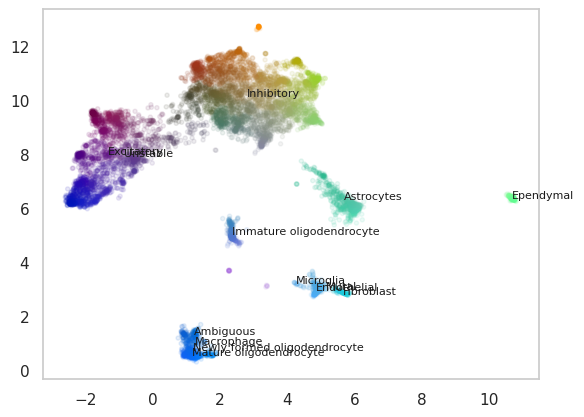

In [ ]:
# define a function that fits expression data to into the umap embeddings:

def transform_embeddings(expression,pca):

    factors = pca.transform(expression)

    embedding = embedder_2d.transform(factors)
    embedding_color = embedder_3d.transform(embedding)
    
    # embedding_color = (embedding_color-color_min)/(color_max-color_min)
    
    return embedding, embedding_color

# define a function that plots the embeddings, with celltype centers rendered as plt.texts on top:
def plot_embeddings(embedding,embedding_color):
    colors = np.clip(embedding_color.copy(),0,1)

    plt.scatter(embedding[:,0],embedding[:,1],c=(colors),alpha=0.1,marker='.')
    for i in range(len(celltypes)):
        plt.text(celltype_centers[i,0],celltype_centers[i,1],celltypes[i],color='k',fontsize=8)


# plot embeddings, with celltype centers rendered as plt.texts on top:
plot_embeddings(embedding,colors)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# define a function that subsamples spots around x,y given a window size:
def get_spatial_subsample_mask(x,y,window_size=5):
    return (spot_df_raw.x>x-window_size)&(spot_df_raw.x<x+window_size)&(spot_df_raw.y>y-window_size)&(spot_df_raw.y<y+window_size)

# define a function that returns the k nearest neighbors of x,y:
def create_knn_graph(coords,k=10):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    return distances, indices

# get a kernel-weighted average of the expression values of the k nearest neighbors of x,y:
def get_knn_expression(distances,neighbor_indices,gene_labels,bandwidth=2.5):

    weights = np.exp(-distances/bandwidth)
    local_expression = pd.DataFrame(index = genes, columns = np.arange(distances.shape[0])).astype(float)

    for i,gene in enumerate(genes):
        weights_ = weights.copy()
        weights_[(gene_labels[neighbor_indices])!=i] = 0
        local_expression.loc[gene,:] = weights_.sum(1)
    
    return local_expression

def pixelmap_to_raw(x,y):
    shift_x = int((spot_df_raw.x/um_per_pixel).min())
    shift_y = int((spot_df_raw.y/um_per_pixel).min())
    return (x+shift_x)*um_per_pixel,(y+shift_y)*um_per_pixel

def raw_to_pixelmap(x,y):
    x = ((spot_df_raw.x/um_per_pixel).astype(int))
    y = ((spot_df_raw.y/um_per_pixel).astype(int))

    return (x/um_per_pixel-x.min()),(y/um_per_pixel-y.min())

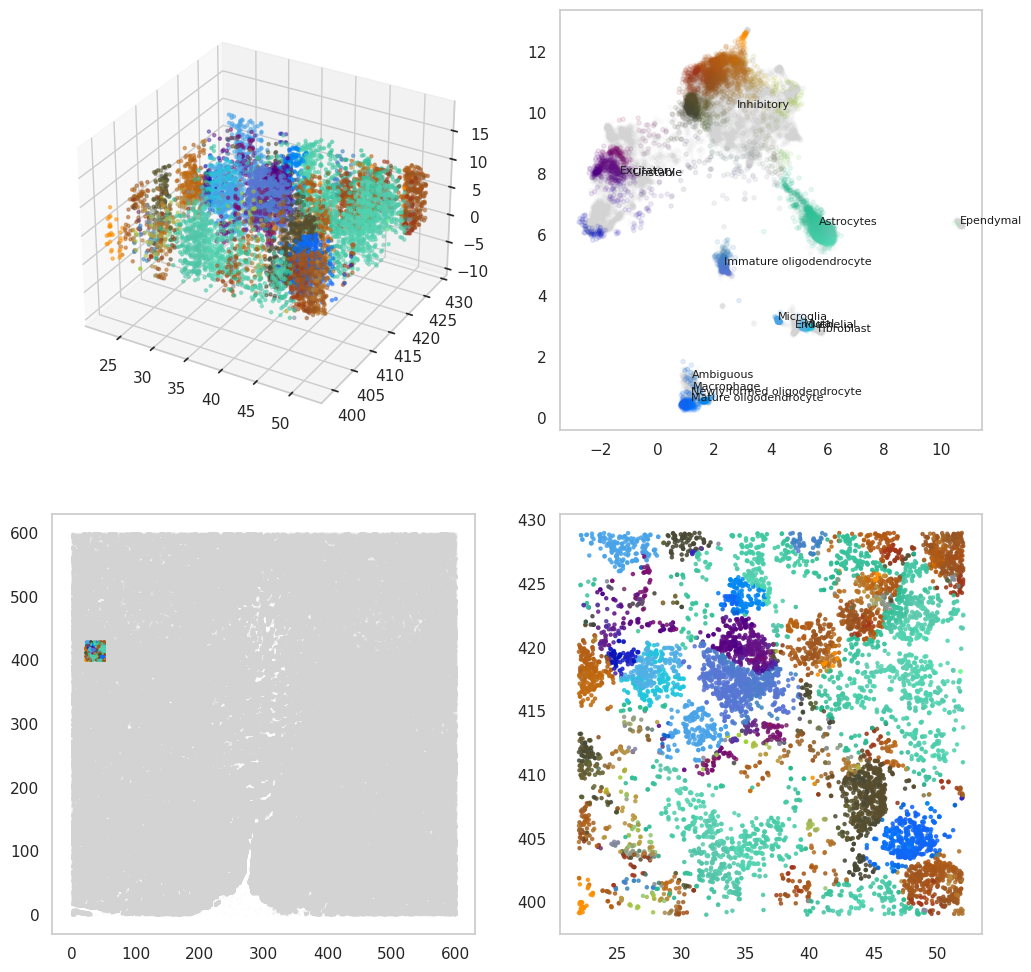

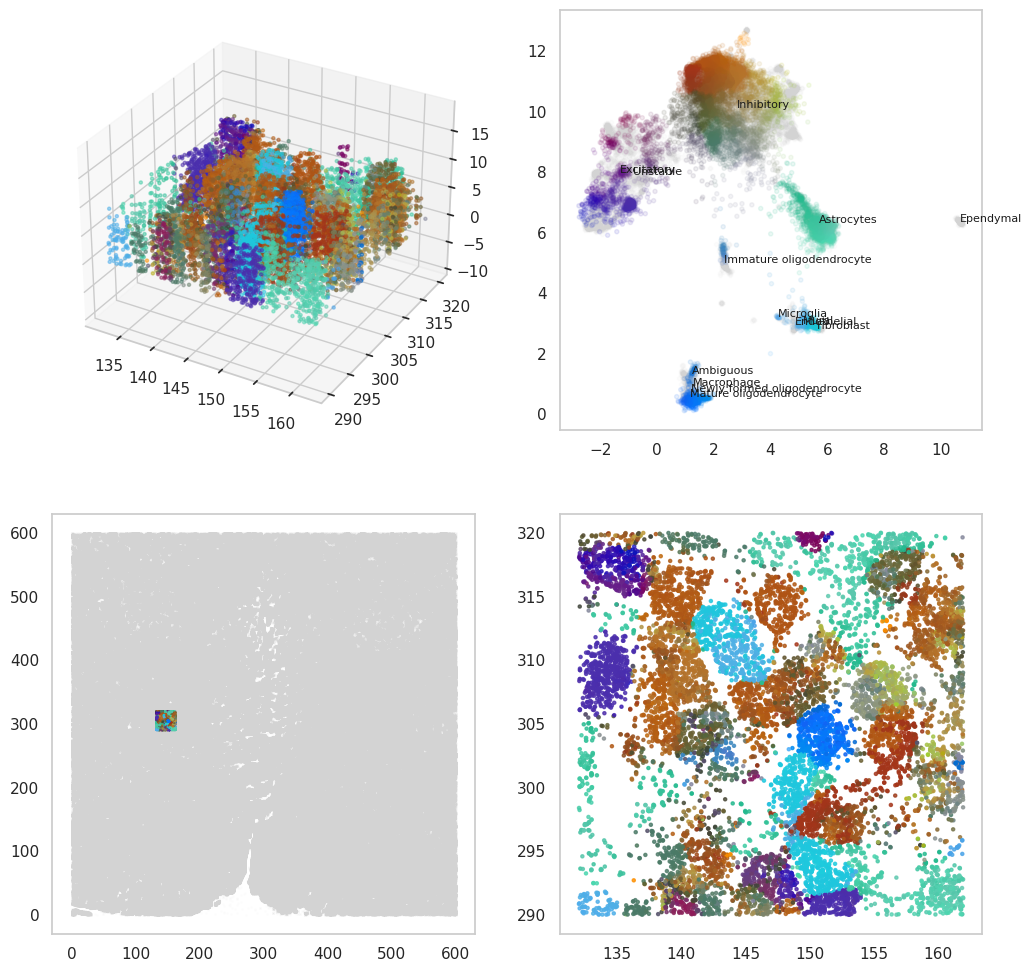

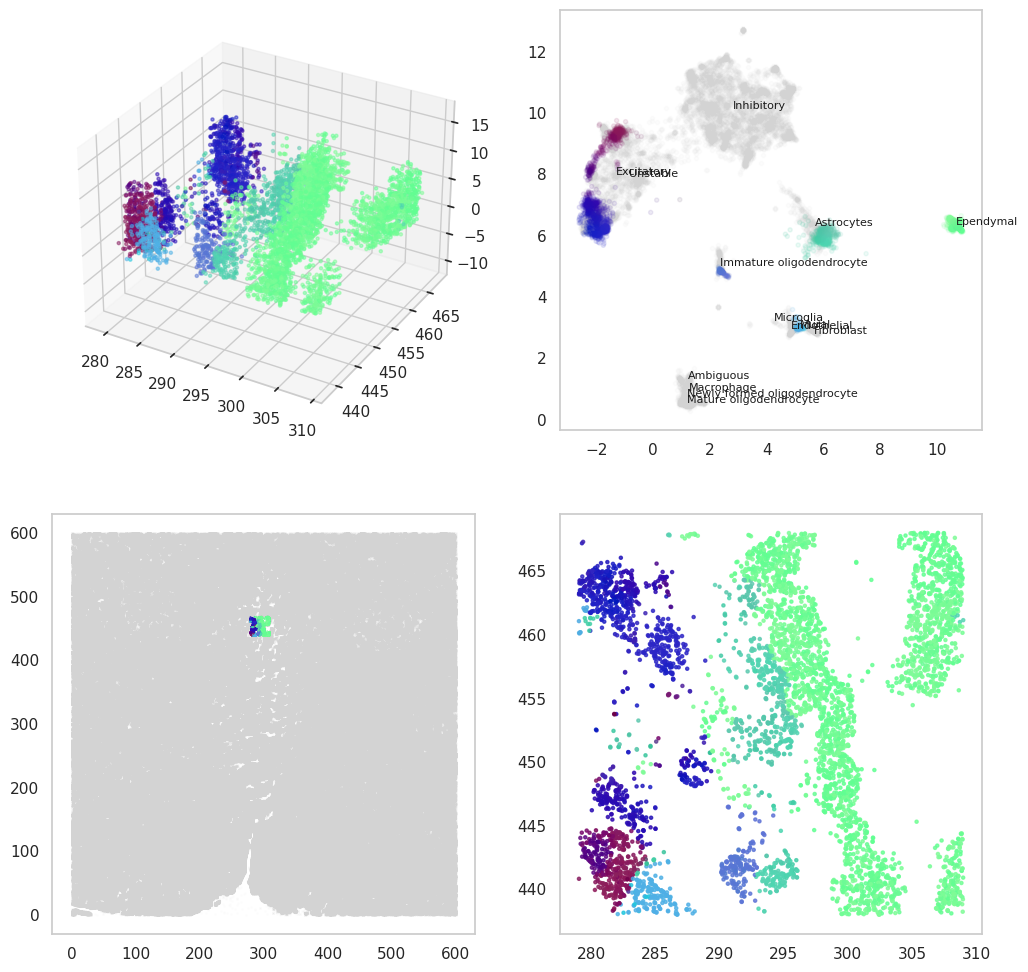

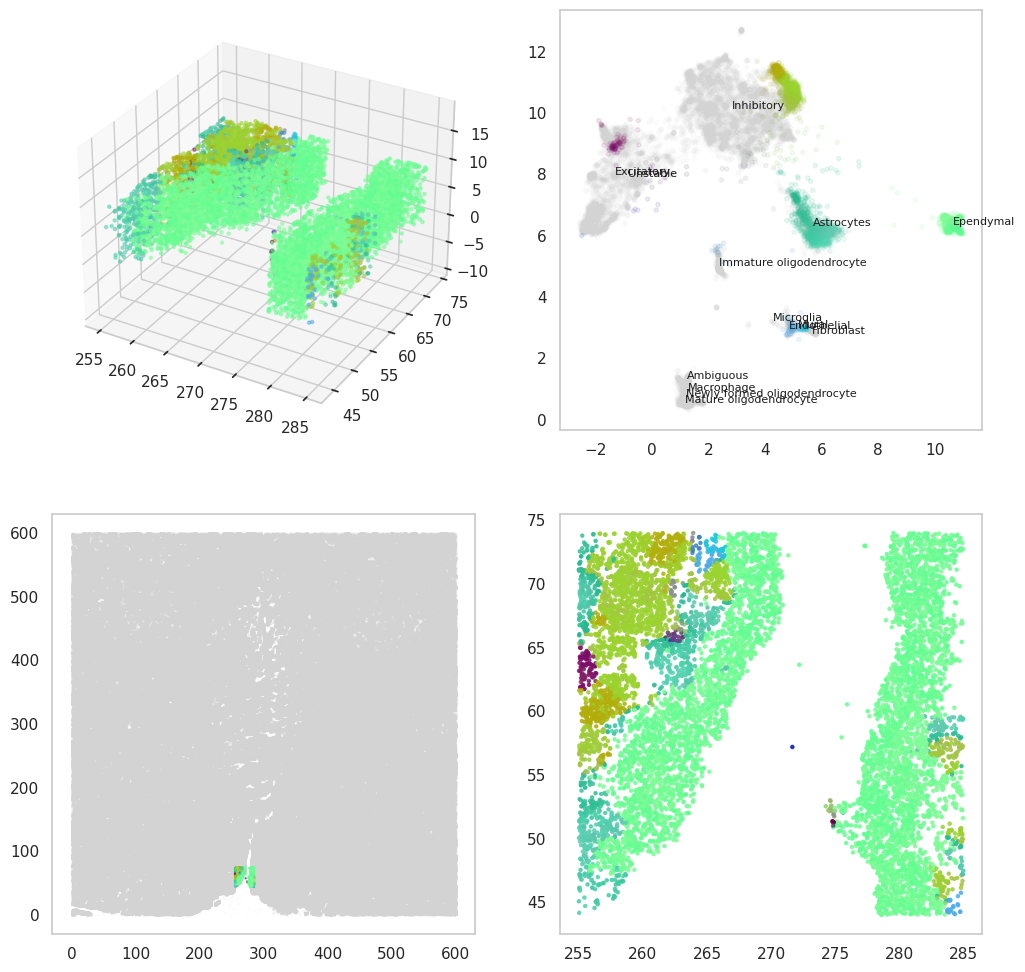

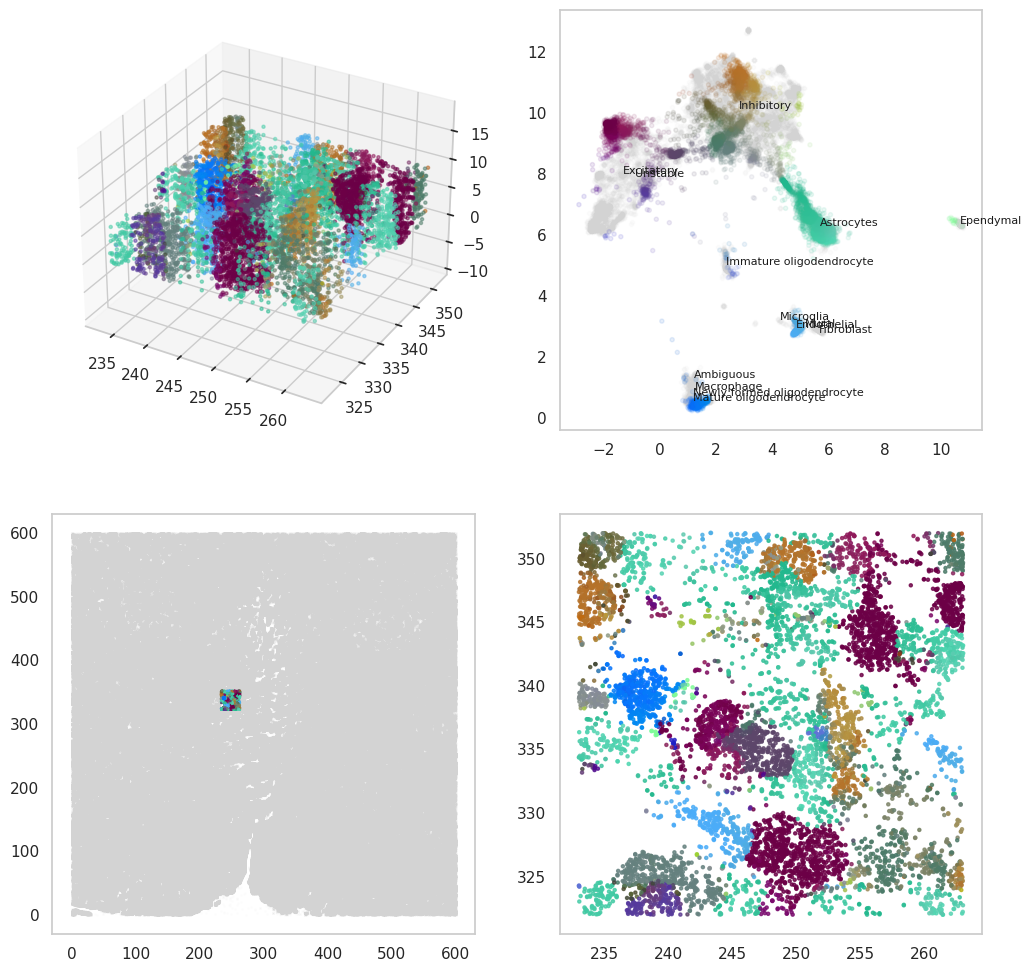

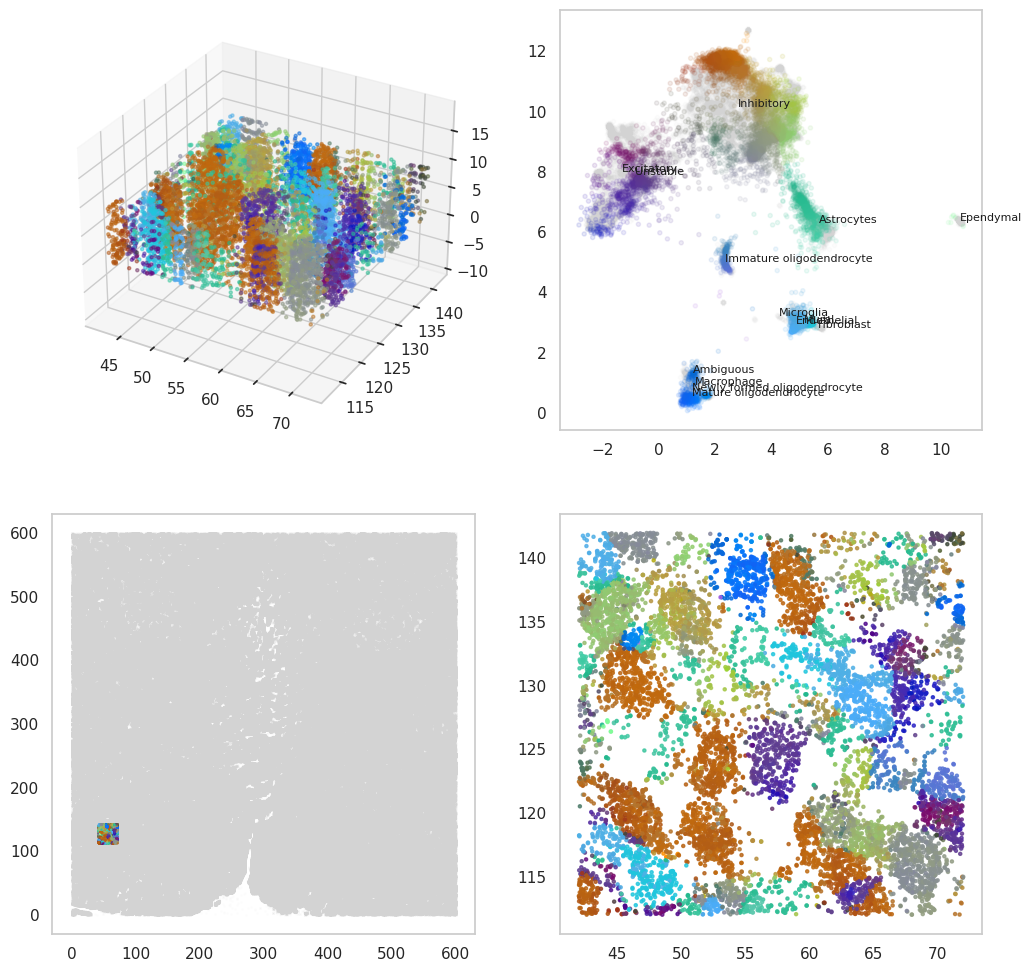

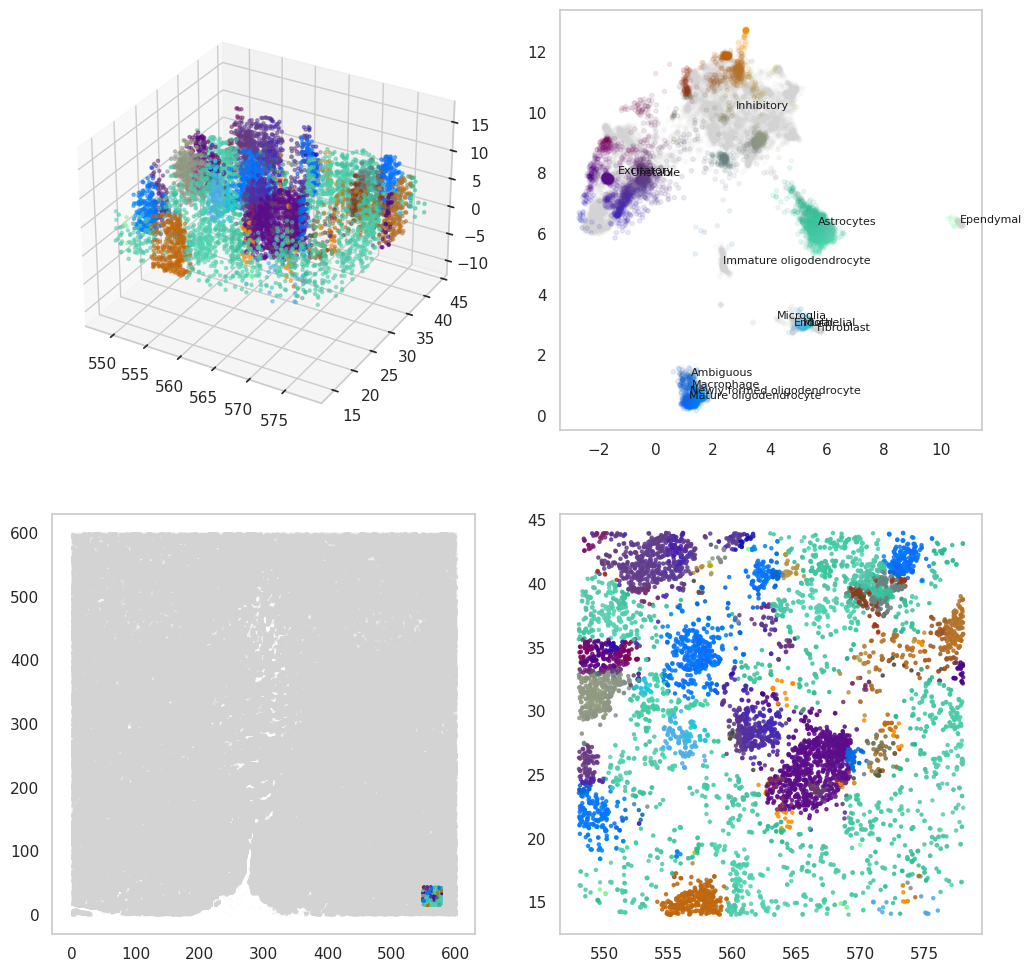

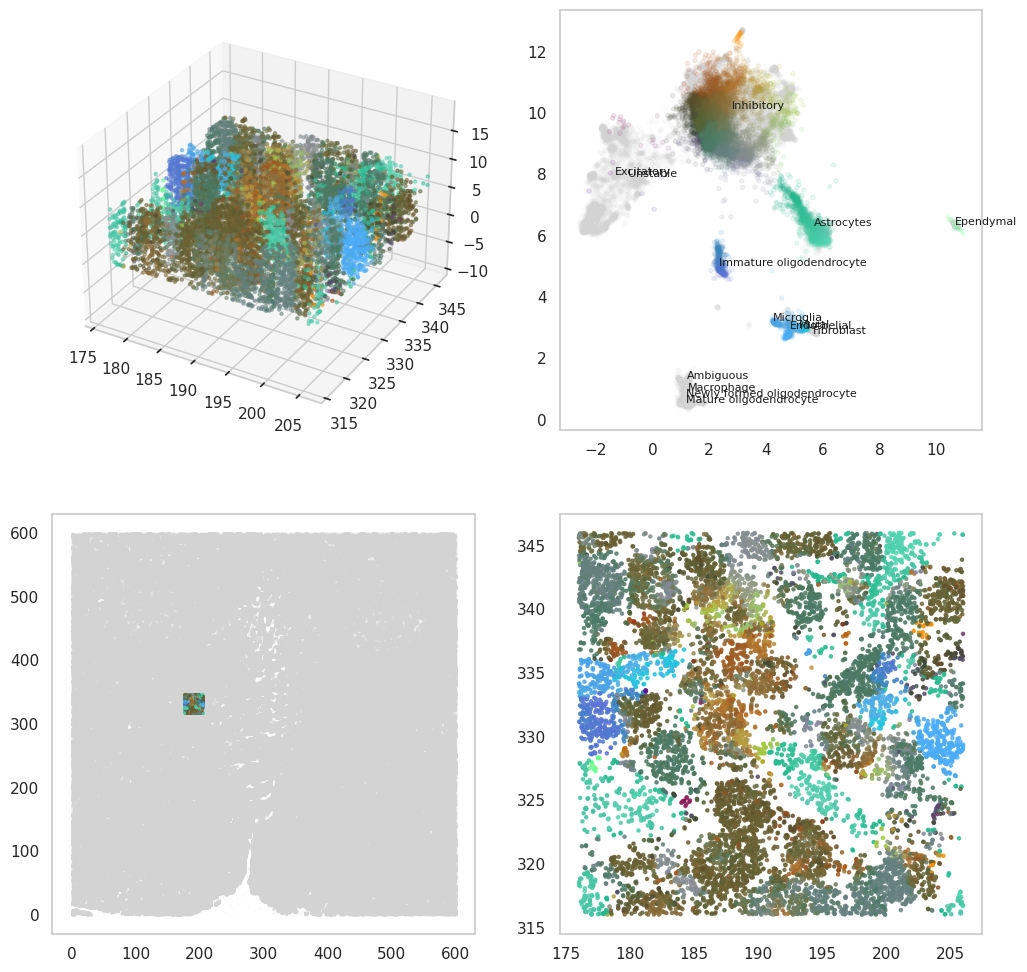

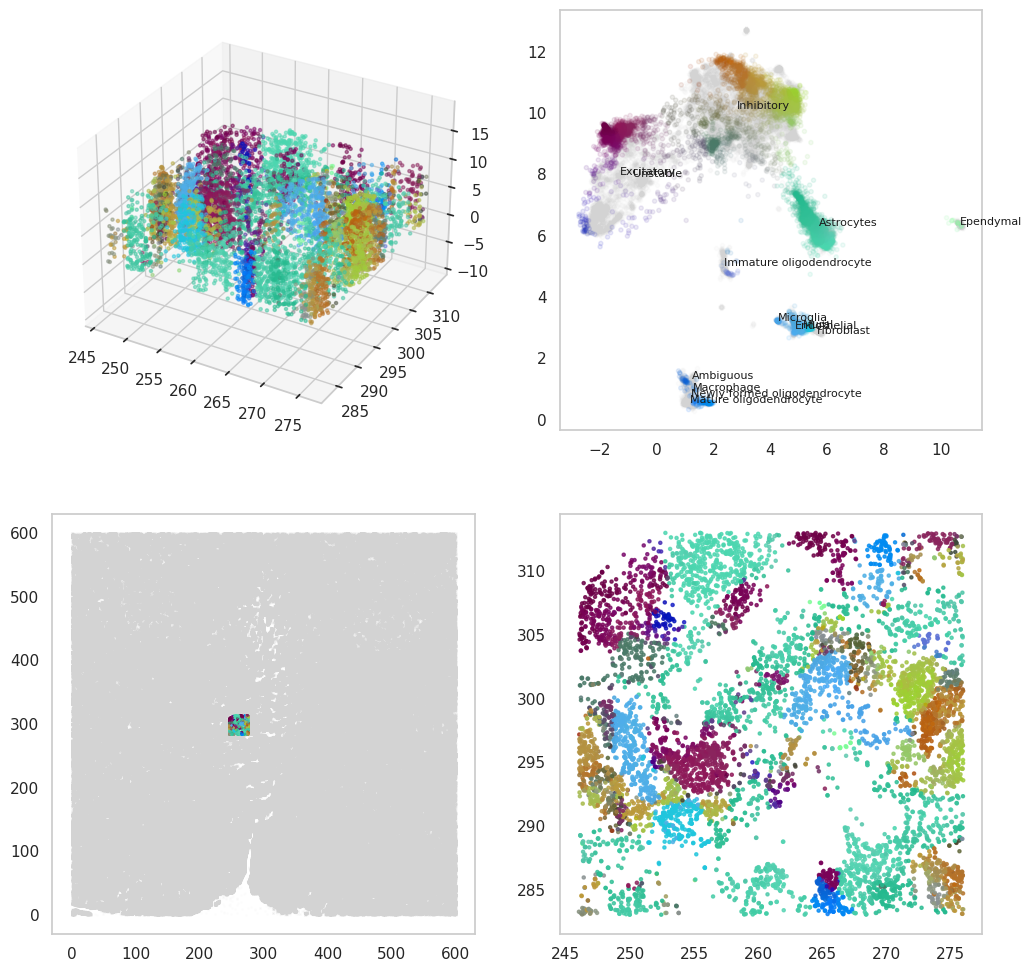

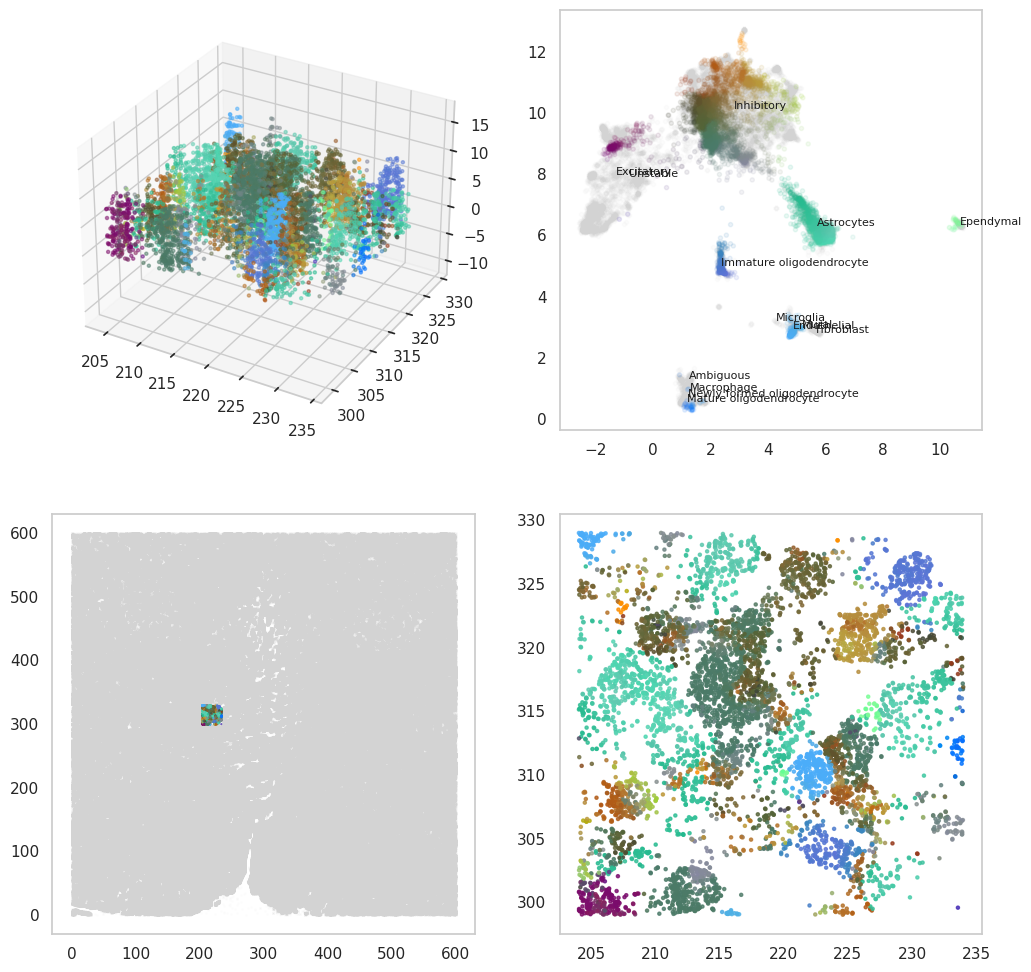

In [ ]:
# plot a case of z-incoherence:

idcs = np.argsort(correlation)

def plot_z_incoherence(n_case,window_size = 15):
        
    # x,y = pixelmap_to_raw(rois_x[idcs[n_case]],rois_y[idcs[n_case]])
    x,y = (rois_x[idcs[n_case]],rois_y[idcs[n_case]])

    subsample_mask = get_spatial_subsample_mask(x,y,window_size=window_size)
    subsample = spot_df_raw[subsample_mask]

    distances, neighbor_indices = create_knn_graph(subsample[['x','y']].values,k=90)
    local_expression = get_knn_expression(distances,neighbor_indices,subsample.gene.cat.codes.values,bandwidth=1.5)
    local_expression = local_expression/((local_expression**2).sum(0)**0.5)
    subsample_embedding, subsample_embedding_color = transform_embeddings(local_expression.T.values,pca)
    subsample_embedding_color,_ = fill_color_axes(subsample_embedding_color,color_pca)
    subsample_embedding_color = (subsample_embedding_color-color_min)/(color_max-color_min)
    subsample_embedding_color = np.clip(subsample_embedding_color,0,1)

    plt.figure(figsize=(12,12))

    ax1 = plt.subplot(221,projection='3d')
    ax1.scatter(subsample.x,subsample.y,subsample.z,c=subsample_embedding_color,marker='.',alpha=0.5)
    ax1.set_zlim(np.median(subsample.z)-window_size,np.median(subsample.z)+window_size)

    ax2 = plt.subplot(222)
    plt.scatter(embedding[:,0],embedding[:,1],c='lightgrey',alpha=0.05,marker='.')
    plot_embeddings(subsample_embedding,subsample_embedding_color)
    # plt.scatter(subsample_embedding[:,0],subsample_embedding[:,1],c=subsample_embedding_color,marker='.',alpha=0.1,s=10)

    ax3 = plt.subplot(223)
    # central_cutout = subsample[(subsample.x<x+5)&(subsample.x>x-5)]
    # ax3.scatter(central_cutout.y,central_cutout.z,c=subsample_embedding_color[(subsample.x<x+5)&(subsample.x>x-5)])
    # ax3.set_ylim(np.median(subsample.z)-window_size/2,np.median(subsample.z)+window_size/2)

    plt.scatter(spot_df_raw.x,spot_df_raw.y,c='lightgrey',alpha=0.05,marker='.',s=1)
    plt.scatter(subsample.x,subsample.y,c=subsample_embedding_color,marker='.',alpha=0.8,s=1)

    ax4 = plt.subplot(224)
    plt.scatter(subsample.x,subsample.y,c=subsample_embedding_color,marker='.',alpha=0.8,s=20)


for i in range(10):
    plot_z_incoherence(i)

In [ ]:
color_max

array([12.87672231, 16.21493319, 14.03950031])